<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Сразу проверим доступность видеокарты и  установим все зависимости и пропишем константы

In [2]:
!nvidia-smi

Sun Apr  6 12:40:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install numpy pandas matplotlib scikit-learn hdbscan kneed
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import hdbscan
import time
import os
from collections import defaultdict
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import os
import json
from datetime import datetime

data_file_path = r"/content/Physical_Activity_Monitoring_unlabeled.csv"
df = pd.read_csv(data_file_path)
output_folder = "Clustering_Results"
df

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.54470,27.3336,-5.766200,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.82570,-15.7719,-1.313950,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.81710,16.3089,25.292800,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.74180,34.3566,21.327400,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.77980,-3.9981,10.995000,0.171133,-0.748343,0.252988,-0.588807,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534596,3479.53,33.8750,-9.084250,4.70122,2.890170,-9.689610,6.78077,3.975430,-0.157406,0.774189,...,0.424520,-0.856836,-25.00990,-23.5557,23.615300,0.318171,-0.701921,0.555778,-0.311745,5
534597,2448.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.767710,-3.050980,-35.70240,31.8018,16.421800,0.435887,0.660643,0.371665,0.485200,5
534598,2479.84,34.6875,-6.367550,2.32131,2.207640,-6.362460,2.33049,2.607610,0.206349,-0.359415,...,-0.034144,-0.402013,-49.69220,20.6039,-0.917908,0.561652,0.297957,0.756767,0.151899,5
534599,3437.82,28.0625,5.461940,10.43640,-9.073300,8.348860,5.76518,-6.143210,3.543910,2.757300,...,0.352062,-5.577750,-34.15510,-11.0786,39.737500,0.062163,-0.798705,-0.056668,-0.595815,6


Волшебная команда для того, чтобы расчеты sklearn осуществлялись на видеокарте

In [4]:
%load_ext cuml.accel

[2025-04-06 12:40:36.425] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-06 12:40:59.793] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-06 12:40:59.794] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-06 12:40:59.794] [CUML] [info] cuML: Successfully initialized accelerator.


Напишем кросс-платформенную функцию для вывода результатов в папку, в названии которой время эксперимента

In [5]:
def setup_environment(output_path=None):
    """
    Создает папку для сохранения результатов анализа с временной меткой.

    Эта функция выполняет следующие действия:
    1. Если путь не указан (output_path=None), создает папку 'Clustering_Results' в текущей рабочей директории
    2. Добавляет временную метку в название папки для уникальности каждого запуска
    3. Создает все необходимые поддиректории (если они не существуют)
    4. Возвращает полный путь к созданной папке

    Параметры:
    ----------
    output_path : str, optional
        Пользовательский путь для сохранения результатов. Если None, будет использована папка по умолчанию.

    Возвращает:
    ----------
    str
        Полный путь к созданной директории для сохранения результатов
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if output_path is None:
        output_path = os.path.join(os.getcwd(), f"Clustering_Results_{timestamp}")
    else:
        base, ext = os.path.splitext(output_path)
        if not ext:
            output_path = f"{base}_{timestamp}"

    os.makedirs(output_path, exist_ok=True)

    print(f"[{datetime.now().strftime('%H:%M:%S')}] Результаты будут сохранены в: {output_path}")
    print(f"Временная метка запуска: {timestamp}")

    return output_path

Напишем функцию для анализа документа

In [6]:
def load_and_analyze_data(data_path, output_folder):
    """
    Загружает данные из файла и выполняет предварительный анализ.

    Функция выполняет следующие операции:
    1. Загружает данные из CSV или Excel файла (автоматически определяя формат)
    2. Выводит основную информацию о данных (размер, первые строки)
    3. Анализирует типы данных и пропущенные значения
    4. Сохраняет полную информацию о данных в текстовый файл

    Параметры:
    ----------
    data_path : str
        Путь к файлу с данными (поддерживаются .csv, .xls, .xlsx)
    output_folder : str
        Директория для сохранения результатов анализа

    Возвращает:
    ----------
    tuple (DataFrame, dict)
        - DataFrame: загруженные данные
        - dict: словарь с информацией о данных:
            * 'shape': размерность данных (строки, столбцы)
            * 'dtypes': типы данных каждого столбца
            * 'missing': количество пропущенных значений по столбцам

    Исключения:
    ----------
    ValueError
        Если передан файл неподдерживаемого формата
    FileNotFoundError
        Если файл по указанному пути не существует

    Пример использования:
    ---------------------
    df, info = load_and_analyze_data('data.csv', 'results/')
    print(info['shape'])  # Выведет: (1000, 15)
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Файл не найден: {data_path}")

    print("="*50)
    print("1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ")
    print("="*50)

    try:
        if data_path.endswith('.csv'):
            df = pd.read_csv(data_path)
        elif data_path.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(data_path)
        else:
            raise ValueError("Неподдерживаемый формат файла. Используйте CSV или Excel.")
    except Exception as e:
        raise ValueError(f"Ошибка при загрузке данных: {str(e)}")

    print(f"\nЗагружено данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print("\nПервые 5 строк данных:")
    print(df.head())

    data_info = {
        'shape': df.shape,
        'dtypes': df.dtypes,
        'missing': df.isna().sum(),
        'numeric_stats': df.describe() if df.select_dtypes(include='number').shape[1] > 0 else None
    }

    report_path = os.path.join(output_folder, 'data_preview.txt')
    try:
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"АНАЛИЗ ДАННЫХ\n{'='*40}\n")
            f.write(f"Файл: {data_path}\n")
            f.write(f"Дата анализа: {pd.Timestamp.now()}\n\n")

            f.write(f"ОБЩАЯ ИНФОРМАЦИЯ\n{'='*40}\n")
            f.write(f"Всего строк: {df.shape[0]}\n")
            f.write(f"Всего столбцов: {df.shape[1]}\n\n")

            f.write(f"ТИПЫ ДАННЫХ\n{'='*40}\n")
            f.write(str(df.dtypes) + "\n\n")

            f.write(f"ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ\n{'='*40}\n")
            f.write(str(df.isna().sum()) + "\n\n")

            if data_info['numeric_stats'] is not None:
                f.write(f"СТАТИСТИКА ПО ЧИСЛОВЫМ ДАННЫМ\n{'='*40}\n")
                f.write(str(data_info['numeric_stats']))

        print(f"\nПолный отчет сохранен в: {report_path}")
    except Exception as e:
        print(f"\nНе удалось сохранить отчет: {str(e)}")

    return df, data_info

Напишем функцию для предварительной обработки данных, удаления ненужных столбцов и заполнения пропусков

In [7]:
def preprocess_data(df, output_folder):
    """
    Выполняет полную предварительную обработку данных для последующего анализа.

    Функция выполняет следующие этапы обработки:
    1. Удаление стандартных нефункциональных столбцов (timestamp, ID и т.д.)
    2. Специальная обработка IMU-данных (интерполяция пропусков)
    3. Заполнение оставшихся пропущенных значений
    4. Масштабирование данных

    Параметры:
    ----------
    df : pandas.DataFrame
        Исходный DataFrame с сырыми данными
    output_folder : str
        Путь для сохранения отчетов о предобработке

    Возвращает:
    ----------
    tuple (numpy.ndarray, Index)
        - X_scaled: массив numpy с обработанными и масштабированными данными
        - columns: названия оставшихся столбцов (после удаления нефункциональных)

    Действия функции:
    ----------------
    1. Удаление нефункциональных столбцов:
       - Автоматически ищет и удаляет столбцы: timestamp, subject_id, time, date, id

    2. Обработка IMU-данных:
       - Идентифицирует IMU-столбцы по ключевым словам (Acc, Gyro, Magne и т.д.)
       - Применяет линейную интерполяцию для заполнения пропусков в IMU-данных

    3. Общая обработка пропусков:
       - Заполняет оставшиеся пропуски медианными значениями

    4. Масштабирование:
       - Стандартизирует данные (среднее=0, дисперсия=1)

    Пример использования:
    --------------------
    X_processed, features = preprocess_data(raw_df, 'preprocessing_reports/')
    """
    print("\n" + "="*50)
    print("2. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
    print("="*50)

    # Создаем копию данных для безопасной обработки
    df_clean = df.copy()

    # 1. Удаление нефункциональных столбцов
    cols_to_drop = []
    standard_cols = ['timestamp', 'subject_id', 'time', 'date', 'id']

    for col in standard_cols:
        if col in df_clean.columns:
            cols_to_drop.append(col)

    if cols_to_drop:
        initial_shape = df_clean.shape
        df_clean = df_clean.drop(cols_to_drop, axis=1)
        print(f"\nУдалено {len(cols_to_drop)} столбцов: {cols_to_drop}")
        print(f"Размер данных изменился с {initial_shape} на {df_clean.shape}")
    else:
        print("\nНе найдено стандартных столбцов для удаления")

    # 2. Специальная обработка IMU-данных
    print("\n[Этап 1/3] Обработка IMU данных...")
    imu_keywords = ['Acc', 'Gyro', 'Magne', 'Temperature', 'Orientation']
    imu_columns = [col for col in df_clean.columns
                  if any(keyword in col for keyword in imu_keywords)]

    if imu_columns:
        # Сохраняем информацию о пропусках до обработки
        na_before = df_clean[imu_columns].isna().sum().sum()

        # Применяем линейную интерполяцию вдоль временной оси (предполагая, что данные упорядочены по времени)
        df_clean[imu_columns] = df_clean[imu_columns].interpolate(
            method='linear',
            limit_direction='both'
        )

        # Анализ результатов интерполяции
        na_after = df_clean[imu_columns].isna().sum().sum()
        print(f"Обработано {len(imu_columns)} IMU-столбцов")
        print(f"Пропусков до интерполяции: {na_before}")
        print(f"Пропусков после интерполяции: {na_after}")
        print(f"Удалено {na_before - na_after} пропусков ({100*(na_before-na_after)/na_before:.1f}%)")
    else:
        print("IMU-столбцы не обнаружены")

    # 3. Заполнение оставшихся пропусков
    print("\n[Этап 2/3] Заполнение оставшихся пропусков...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_clean)

    # 4. Масштабирование данных
    print("\n[Этап 3/3] Масштабирование данных...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Сохранение отчетов
    preprocessing_report = {
        'removed_columns': cols_to_drop,
        'imu_columns_processed': imu_columns,
        'na_values_before': na_before if 'imu_columns' in locals() else None,
        'na_values_after': na_after if 'imu_columns' in locals() else None,
        'imputation_strategy': 'median',
        'scaling_method': 'StandardScaler (mean=0, std=1)'
    }

    report_path = os.path.join(output_folder, 'preprocessing_report.txt')
    with open(report_path, 'w') as f:
        for key, value in preprocessing_report.items():
            f.write(f"{key}: {value}\n")

    print(f"\nОтчет о предобработке сохранен в: {report_path}")
    print("="*50)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА")
    print("="*50)

    return X_scaled, df_clean.columns

Пишем функцию для  уменьшения размерности данных (отбросим шумовые признаки)

In [8]:
def reduce_dimensionality(X_scaled, output_folder):
    """
    Выполняет уменьшение размерности данных с помощью PCA и визуализирует результаты.

    Функция выполняет следующие операции:
    1. Полный PCA-анализ для определения важности компонент
    2. Визуализацию накопленной объясненной дисперсии
    3. Автоматический выбор числа компонент, сохраняющих 95% дисперсии
    4. Преобразование данных в пространство главных компонент

    Параметры:
    ----------
    X_scaled : numpy.ndarray
        Масштабированные данные (форма: n_samples × n_features)
    output_folder : str
        Директория для сохранения графиков и результатов анализа

    Возвращает:
    ----------
    numpy.ndarray
        Массив данных в уменьшенном пространстве (форма: n_samples × n_components)

    Детали работы:
    -------------
    1. Анализ объясненной дисперсии:
       - Вычисляет вклад каждой компоненты
       - Строит график кумулятивной дисперсии

    2. Выбор числа компонент:
       - Автоматически определяет минимальное число компонент,
         объясняющих 95% дисперсии
       - Сохраняет график в указанную директорию

    3. Преобразование данных:
       - Проецирует данные на выбранные главные компоненты
       - Возвращает данные в уменьшенном пространстве

    Пример использования:
    --------------------
    X_reduced = reduce_dimensionality(X_scaled, 'output/pca_results/')
    """
    print("\n" + "="*50)
    print("3. АНАЛИЗ И УМЕНЬШЕНИЕ РАЗМЕРНОСТИ (PCA)")
    print("="*50)

    # 1. Полный PCA анализ
    print("\nВыполнение полного PCA анализа...")
    pca_full = PCA().fit(X_scaled)

    # 2. Визуализация объясненной дисперсии
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_),
             linewidth=2, color='blue')
    plt.axhline(y=0.95, color='red', linestyle='--',
                label='95% дисперсии')
    plt.xlabel('Количество компонент', fontsize=12)
    plt.ylabel('Накопленная объясненная дисперсия', fontsize=12)
    plt.title('Объясненная дисперсия главных компонент', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Сохранение графика
    plot_path = os.path.join(output_folder, 'pca_variance.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"График дисперсии сохранен: {plot_path}")

    # 3. Автоматический выбор числа компонент
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1

    print(f"\nОбщее число компонент: {X_scaled.shape[1]}")
    print(f"Выбрано компонент: {n_components} (сохраняют 95% дисперсии)")
    print(f"Доля сохраняемой дисперсии: {cumulative_variance[n_components-1]:.4f}")

    # 4. Преобразование данных
    print("\nПрименение PCA преобразования...")
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)

    # Сохранение информации о PCA
    pca_info = {
        'original_dim': X_scaled.shape[1],
        'reduced_dim': n_components,
        'explained_variance': cumulative_variance[n_components-1],
        'components': pca.components_,
        'feature_names': getattr(X_scaled, 'columns', None)  # если передан DataFrame
    }

    info_path = os.path.join(output_folder, 'pca_info.npy')
    np.save(info_path, pca_info, allow_pickle=True)
    print(f"\nИнформация о PCA сохранена: {info_path}")

    print("\n" + "="*50)
    print("УМЕНЬШЕНИЕ РАЗМЕРНОСТИ ЗАВЕРШЕНО")
    print("="*50)

    return X_reduced

Напишем функцию для кластеризации (2 разных варианта)

In [9]:
def perform_clustering(X_reduced, output_folder, method='hdbscan', params=None):
    """
    Выполняет кластеризацию данных с использованием указанного метода.

    Поддерживаемые методы:
    - 'hdbscan' (по умолчанию)
    - 'agg' (AgglomerativeClustering)

    Параметры:
    ----------
    X_reduced : array-like
        Данные для кластеризации (после уменьшения размерности)
    output_folder : str
        Директория для сохранения результатов и параметров
    method : str, optional
        Метод кластеризации ('hdbscan' или 'agg')
    params : dict, optional
        Параметры для алгоритма кластеризации. Если None, используются значения по умолчанию

    Возвращает:
    ----------
    Объект кластеризации с атрибутами:
    - labels_ : метки кластеров
    - probabilities_ : вероятности принадлежности (только для HDBSCAN)
    """

    # Параметры по умолчанию для каждого метода
    default_params = {
        'hdbscan': {
            'min_cluster_size': 200,
            'min_samples': 20,
            'cluster_selection_epsilon': 0.5,
            'cluster_selection_method': 'leaf',
            'metric': 'euclidean',
            'core_dist_n_jobs': -1
        },
        'agg': {
            'n_clusters': None,
            'distance_threshold': 0.5,
            'linkage': 'ward',
            'metric': 'euclidean'
        }
    }

    # Проверка и установка параметров
    if params is None:
        params = default_params[method]
    else:
        # Объединяем с параметрами по умолчанию
        params = {**default_params[method], **params}

    print("\n" + "="*50)
    print(f"4. КЛАСТЕРИЗАЦИЯ {method.upper()}")
    print("="*50)
    print("Параметры кластеризации:")
    print(pd.Series(params))

    # Создаем директорию, если не существует
    os.makedirs(output_folder, exist_ok=True)

    # Сохранение параметров
    param_path = os.path.join(output_folder, f'{method}_params.csv')
    pd.Series(params).to_csv(param_path)
    print(f"\nПараметры сохранены в: {param_path}")

    # Выполнение кластеризации
    print("\nЗапуск кластеризации...")
    start_time = time.time()

    try:
        if method == 'hdbscan':
            clusterer = hdbscan.HDBSCAN(**params)
            clusterer.fit(X_reduced)
            result = clusterer
        elif method == 'agg':
            clusterer = AgglomerativeClustering(**params)
            labels = clusterer.fit_predict(X_reduced)

            # Создаем объект с совместимым интерфейсом
            class ClusterResult:
                def __init__(self, labels):
                    self.labels_ = labels
                    self.probabilities_ = None

            result = ClusterResult(labels)
        else:
            raise ValueError(f"Неизвестный метод кластеризации: {method}. Доступные варианты: 'hdbscan', 'agg'")

        duration = (time.time() - start_time)/60
        print(f"\nКластеризация завершена за {duration:.2f} минут")

        # Анализ результатов кластеризации
        unique_labels = np.unique(result.labels_)
        if method == 'hdbscan':
            unique_labels = unique_labels[unique_labels != -1]  # Исключаем шум

        # Сохранение информации о выполнении
        time_info = {
            'method': method,
            'duration_min': round(duration, 2),
            'n_clusters': len(unique_labels),
            'params': params,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }

        time_path = os.path.join(output_folder, f'{method}_time_info.json')
        with open(time_path, 'w') as f:
            json.dump(time_info, f, indent=2)

        print(f"\nНайдено кластеров: {len(unique_labels)}")
        print(f"\nИнформация о выполнении сохранена в: {time_path}")

    except Exception as e:
        print(f"\nОШИБКА ПРИ КЛАСТЕРИЗАЦИИ: {str(e)}")
        raise

    print("\n" + "="*50)
    print(f"КЛАСТЕРИЗАЦИЯ {method.upper()} ЗАВЕРШЕНА")
    print("="*50)

    return result

И функцию для оценки результатов

In [10]:
def analyze_results(clusterer, X_scaled, output_folder, method='hdbscan'):
    """
    Анализирует и визуализирует результаты кластеризации.

    Параметры:
    ----------
    clusterer : объект кластеризации
        Модель после обучения (HDBSCAN или AgglomerativeClustering)
    X_scaled : array-like
        Масштабированные исходные данные
    output_folder : str
        Директория для сохранения результатов
    method : str
        Использованный метод кластеризации ('hdbscan' или 'agg')

    Возвращает:
    ----------
    tuple (dict, pd.Series, np.array)
        - Статистика кластеризации
        - Распределение по кластерам
        - Метки кластеров
    """
    print("\n" + "="*50)
    print(f"5. АНАЛИЗ РЕЗУЛЬТАТОВ ({method.upper()})")
    print("="*50)

    labels = clusterer.labels_

    # Анализ шума (только для HDBSCAN)
    noise_analysis = {}
    if method == 'hdbscan':
        n_noise = (labels == -1).sum()
        noise_analysis = {
            'n_noise': n_noise,
            'noise_percentage': n_noise/len(labels)*100
        }

    # Основная статистика
    unique_clusters = np.unique(labels[labels != -1]) if method == 'hdbscan' else np.unique(labels)

    # Исправленная проверка вероятностей
    has_probabilities = hasattr(clusterer, 'probabilities_') and clusterer.probabilities_ is not None
    avg_probability = clusterer.probabilities_.mean() if has_probabilities else None

    stats = {
        'method': method,
        'total_points': len(labels),
        'n_clusters': len(unique_clusters),
        **noise_analysis,
        'avg_probability': avg_probability
    }

    # Вывод статистики
    print("\nОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
    print(f"- Метод кластеризации: {method.upper()}")
    print(f"- Всего точек: {stats['total_points']}")
    print(f"- Кластеров: {stats['n_clusters']}")

    if method == 'hdbscan':
        print(f"- Шум (-1): {stats['n_noise']} ({stats['noise_percentage']:.1f}%)")
        if stats['avg_probability'] is not None:
            print(f"- Средняя вероятность: {stats['avg_probability']:.2f}")

    # Анализ распределения кластеров
    cluster_stats = pd.Series(labels).value_counts().sort_index()
    print("\nРАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:")
    print(cluster_stats.head(20))

    # Сохранение результатов
    save_analysis_results(stats, cluster_stats, output_folder, method)
    visualize_clusters(X_scaled, labels, output_folder, method)

    return stats, cluster_stats, labels

А теперь сохраняем и визуализируем результаты

In [11]:
def save_analysis_results(stats, cluster_stats, output_folder, method):
    """Сохраняет результаты анализа в файлы"""
    # Преобразуем все значения типа int64 и float32 в int и float соответственно
    stats = {k: int(v) if isinstance(v, np.int64) else float(v) if isinstance(v, np.float32) else v for k, v in stats.items()}

    # Сохранение статистики в JSON
    stats_path = os.path.join(output_folder, f'{method}_stats.json')
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, indent=2, ensure_ascii=False)

    # Сохранение распределения кластеров
    cluster_stats_path = os.path.join(output_folder, f'{method}_cluster_distribution.csv')
    cluster_stats.to_csv(cluster_stats_path, header=['count'])

    print(f"\nРезультаты сохранены в:\n- {stats_path}\n- {cluster_stats_path}")

def visualize_clusters(X, labels, output_folder, method):
    """
    Создает визуализации кластеров в 2D и 3D пространствах.
    """
    print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...")

    # 2D визуализация
    pca_2d = PCA(n_components=2)
    X_2d = pca_2d.fit_transform(X)

    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels,
                         cmap='Spectral', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Кластер')
    plt.title(f'Кластеризация {method.upper()} (2D проекция)')
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.grid(alpha=0.3)

    plot_path = os.path.join(output_folder, f'{method}_clusters_2d.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"- 2D визуализация сохранена: {plot_path}")


Перенумеровываем ячейки по тз

In [12]:
import os
import json
import numpy as np
import pandas as pd

def renumber_and_save_clusters(labels, output_folder, method='hdbscan'):
    """
    Перенумеровывает кластеры по порядку и сохраняет результаты.

    Возвращает:
    ----------
    pd.DataFrame
        DataFrame с колонками ['Index', 'ClusterID']
    """
    print("\n" + "="*50)
    print(f"6. ПЕРЕНУМЕРАЦИЯ И СОХРАНЕНИЕ ({method.upper()})")
    print("="*50)

    # Создаем DataFrame с результатами
    result_df = pd.DataFrame({
        'Index': np.arange(len(labels)),
        'ClusterID': labels
    })

    # Перенумерация кластеров (включая шум)
    valid_clusters = result_df['ClusterID'].unique()

    # Создаем маппинг кластеров, включая шум
    cluster_mapping = {int(old): i for i, old in enumerate(sorted(valid_clusters))}

    # Применяем маппинг к кластерам
    result_df['ClusterID'] = result_df['ClusterID'].map(cluster_mapping)

    # Сохранение результатов
    result_path = os.path.join(output_folder, f'clusters_{method}.csv')
    result_df.to_csv(result_path, index=False)

    # Сохранение маппинга кластеров
    mapping_path = os.path.join(output_folder, f'cluster_mapping_{method}.json')
    with open(mapping_path, 'w') as f:
        json.dump(cluster_mapping, f, indent=2)

    print("\nРЕЗУЛЬТАТ ПЕРЕНУМЕРАЦИИ:")
    print(result_df.head())
    print(f"\nФайлы сохранены:\n- Результаты: {result_path}\n- Маппинг: {mapping_path}")
    print(f"Всего кластеров: {len(valid_clusters)}")

    return result_df

Готовим основной пайплайн

In [12]:
def main(data_path, clustering_method='hdbscan', output_path=None, params=None):
    """
    Основной пайплайн обработки данных и кластеризации.
    """
    try:
        # 1. Настройка среды
        output_folder = setup_environment(output_path)

        # 2. Загрузка и анализ данных
        df, data_info = load_and_analyze_data(data_path, output_folder)

        # 3. Предварительная обработка
        X_scaled, feature_names = preprocess_data(df, output_folder)

        # 4. Уменьшение размерности
        X_reduced = reduce_dimensionality(X_scaled, output_folder)

        # 5. Кластеризация
        cluster_result = perform_clustering(
            X_reduced,
            output_folder,
            method=clustering_method,
            params=params
        )

        # 6. Анализ и сохранение результатов
        stats, cluster_stats, labels = analyze_results(
            cluster_result,
            X_scaled,
            output_folder,
            clustering_method
        )

        # 7. Перенумерация кластеров
        final_result = renumber_and_save_clusters(
            labels,
            output_folder,
            clustering_method
        )

        print("\n" + "="*50)
        print("ОБРАБОТКА УСПЕШНО ЗАВЕРШЕНА")
        print("="*50)

        return {
            'data': X_scaled,
            'features': feature_names,
            'result': final_result,
            'stats': stats,
            'cluster_stats': cluster_stats
        }

    except Exception as e:
        print(f"\nОШИБКА: {str(e)}")
        raise


Запускаем кластеризацию по методу hdbscan

In [27]:
from datetime import datetime
# Выбираем метод кластеризации ('hdbscan' или 'agg')
clustering_method = 'hdbscan'

# Запуск анализа
results = main(
    data_path=data_file_path,
    clustering_method=clustering_method,
    # output_path=output_directory,
    # hdbscan_params=hdbscan_parameters,
    # agg_params=agg_parameters
)

[12:17:14] Результаты будут сохранены в: /content/Clustering_Results_2025-04-06_12-17-14
Временная метка запуска: 2025-04-06_12-17-14
1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ

Загружено данных: 534601 строк, 53 столбцов

Первые 5 строк данных:
   timestamp  handTemperature  handAcc16_1  handAcc16_2  handAcc16_3  \
0     252.75          34.8750     0.902847      7.45872     6.032490   
1    3652.45          29.7500    -4.069330      3.76168     8.279720   
2     504.76          34.3750    -2.007540     -9.60180     0.773674   
3    2801.61          31.9375   -13.262200      5.85443     0.899334   
4     441.01          33.5000    -0.013940      8.66540     4.398210   

   handAcc6_1  handAcc6_2  handAcc6_3  handGyro1  handGyro2  ...  ankleGyro2  \
0    1.006100     7.44575    6.303650  -0.021952   0.004114  ...   -0.025606   
1   -5.972500     3.22273    6.908970   0.116054  -0.375968  ...   -0.670163   
2   -1.803500    -9.58937    1.073680   0.020131   0.042189  ...   -0.009741   
3  -13.611500   

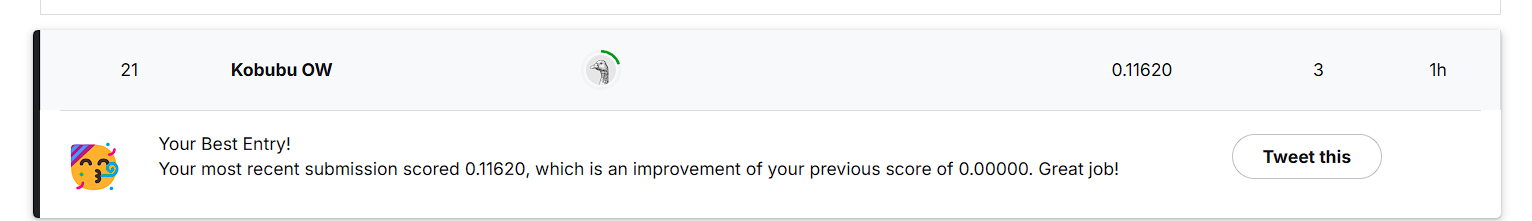![image.png](attachment:image.png)

#Запускаем кластеризацию по методу AgglomerativeClustering

In [ ]:
from datetime import datetime
from kneed import KneeLocator
# Выбираем метод кластеризации ('hdbscan' или 'agg')
clustering_method = 'agg'

# Запуск анализа
results = main(
    data_path=data_file_path,
    clustering_method=clustering_method,
    # output_path=output_directory,
    # hdbscan_params=hdbscan_parameters,
    # agg_params=agg_parameters
)

[12:38:36] Результаты будут сохранены в: /content/Clustering_Results_2025-04-06_12-38-36
Временная метка запуска: 2025-04-06_12-38-36
1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ

Загружено данных: 534601 строк, 53 столбцов

Первые 5 строк данных:
   timestamp  handTemperature  handAcc16_1  handAcc16_2  handAcc16_3  \
0     252.75          34.8750     0.902847      7.45872     6.032490   
1    3652.45          29.7500    -4.069330      3.76168     8.279720   
2     504.76          34.3750    -2.007540     -9.60180     0.773674   
3    2801.61          31.9375   -13.262200      5.85443     0.899334   
4     441.01          33.5000    -0.013940      8.66540     4.398210   

   handAcc6_1  handAcc6_2  handAcc6_3  handGyro1  handGyro2  ...  ankleGyro2  \
0    1.006100     7.44575    6.303650  -0.021952   0.004114  ...   -0.025606   
1   -5.972500     3.22273    6.908970   0.116054  -0.375968  ...   -0.670163   
2   -1.803500    -9.58937    1.073680   0.020131   0.042189  ...   -0.009741   
3  -13.611500   

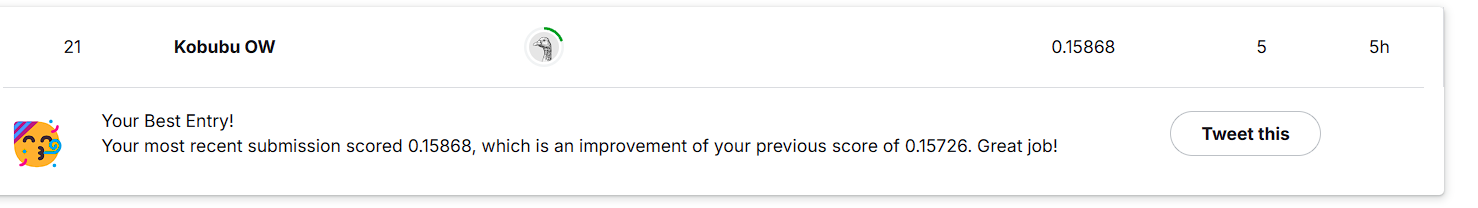

Чуть получше, но теперь попробуем помочь себе с помощью

А теперь попробуем помочь себе с помощью метода ближайших соседей

In [ ]:
def plot_k_distance(X, k=None, output_folder=None):
    """
    Функция для построения графика k-distance и определения оптимального epsilon
    """
    if k is None:
        # Эмпирическое правило для min_samples (можно настроить)
        k = min(5, max(2, int(2 * np.log(X.shape[0]))))

    print(f"\nПостроение k-distance графика для k={k}...")

    # Вычисляем расстояния до k-го ближайшего соседа
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)

    # Сортируем расстояния
    k_distances = np.sort(distances[:, -1], axis=0)

    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.xlabel('Точки, отсортированные по расстоянию')
    plt.ylabel(f'Расстояние до {k}-го соседа')
    plt.title(f'k-distance график (k={k})')
    plt.grid(True)

    # Сохраняем график
    if output_folder:
        plot_path = os.path.join(output_folder, f'k_distance_plot_k{k}.png')
        plt.savefig(plot_path, bbox_inches='tight')
        print(f"График сохранен: {plot_path}")

    plt.show()

    # Автоматическое определение "колена" (можно использовать для выбора epsilon)
    kneedle = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
    if kneedle.knee:
        epsilon = k_distances[kneedle.knee]
        print(f"\nРекомендуемое значение epsilon (на основе 'колена'): {epsilon:.4f}")
        print(f"Рекомендуемое min_samples: {k} (использованное k)")
    else:
        epsilon = np.percentile(k_distances, 95)  # Альтернативный метод, если колено не найдено
        print(f"\nНе удалось четко определить 'колено'. Альтернативное значение epsilon (95-й персентиль): {epsilon:.4f}")
        print(f"Рекомендуемое min_samples: {k} (использованное k)")

    return epsilon, k

# Модифицированная функция perform_hdbscan_clustering
def perform_hdbscan_clustering(X_reduced, output_folder, auto_params=True):
    """Кластеризация с HDBSCAN с возможностью автоматического подбора параметров"""
    print("\n" + "="*50)
    print("4. КЛАСТЕРИЗАЦИЯ HDBSCAN")
    print("="*50)

    if auto_params:
        # Автоматический подбор параметров на основе k-distance графика
        epsilon, min_samples = plot_k_distance(X_reduced, k=None, output_folder=output_folder)

        params = {
            'min_cluster_size': min_samples * 2,  # Эмпирическое правило
            'min_samples': min_samples,
            'cluster_selection_epsilon': epsilon,
            'cluster_selection_method': 'eom',
            'metric': 'euclidean',
            'core_dist_n_jobs': -1
        }
    else:
        # Ручные параметры (по умолчанию)
        params = {
            'min_cluster_size': 200,
            'min_samples': 20,
            'cluster_selection_epsilon': 0.5,
            'cluster_selection_method': 'leaf',
            'metric': 'euclidean',
            'core_dist_n_jobs': -1
        }

    print("\nИспользуемые параметры кластеризации:")
    print(pd.Series(params))

    params_file = os.path.join(output_folder, 'hdbscan_params.csv')
    pd.Series(params).to_csv(params_file)

    print("\nЗапуск кластеризации...")
    start_time = time.time()

    clusterer = HDBSCAN(**params)
    clusterer.fit(X_reduced)

    print(f"Кластеризация завершена за {(time.time()-start_time)/60:.2f} минут")

    return clusterer

# Модифицированная главная функция
def easy_main(clustering_method='hdbscan', output_folder=r"./Clustering_Results", auto_params=True):
    try:
        # 1. Настройка среды
        output_folder = setup_environment(output_folder)

        # 2. Загрузка и анализ данных
        data_info = load_and_analyze_data(data_file_path, output_folder)

        # 3. Предварительная обработка
        X_scaled, feature_names = preprocess_data(df, output_folder)

        # 4. Уменьшение размерности
        X_reduced = reduce_dimensionality(X_scaled, output_folder)

        # 5. Кластеризация
        if clustering_method == 'hdbscan':
            clusterer = perform_hdbscan_clustering(X_reduced, output_folder, auto_params)
        elif clustering_method == 'agg':
            clusterer = perform_agg_clustering(X_reduced, output_folder)
        else:
            raise ValueError("Неизвестный метод кластеризации. Доступные варианты: 'hdbscan' или 'agg'")

        # 6. Анализ результатов
        stats, cluster_stats, new_labels = analyze_results(clusterer, X_scaled, output_folder)

        # 7. Перенумерация кластеров и сохранение
        final_result = renumber_and_save_clusters(new_labels, output_folder)

        print("\n" + "="*50)
        print("ОБРАБОТКА УСПЕШНО ЗАВЕРШЕНА")
        print("="*50)

    except Exception as e:
        print(f"\nОШИБКА: {str(e)}")
        raise

#ну и запустим сразу
data_file_path = r"/content/Physical_Activity_Monitoring_unlabeled.csv"
df = pd.read_csv(data_file_path)
easy_main(clustering_method='hdbscan', output_folder=r"./Clustering_Results", auto_params=True)

[12:41:06] Результаты будут сохранены в: ./Clustering_Results_2025-04-06_12-41-06
Временная метка запуска: 2025-04-06_12-41-06
1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ

Загружено данных: 534601 строк, 53 столбцов

Первые 5 строк данных:
   timestamp  handTemperature  handAcc16_1  handAcc16_2  handAcc16_3  \
0     252.75          34.8750     0.902847      7.45872     6.032490   
1    3652.45          29.7500    -4.069330      3.76168     8.279720   
2     504.76          34.3750    -2.007540     -9.60180     0.773674   
3    2801.61          31.9375   -13.262200      5.85443     0.899334   
4     441.01          33.5000    -0.013940      8.66540     4.398210   

   handAcc6_1  handAcc6_2  handAcc6_3  handGyro1  handGyro2  ...  ankleGyro2  \
0    1.006100     7.44575    6.303650  -0.021952   0.004114  ...   -0.025606   
1   -5.972500     3.22273    6.908970   0.116054  -0.375968  ...   -0.670163   
2   -1.803500    -9.58937    1.073680   0.020131   0.042189  ...   -0.009741   
3  -13.611500     5.915